In [16]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pathlib import Path
from typing import Optional, Union, List, Tuple
import yaml

from utils import xml_timeinfo, xml_parameters, read_tss, KGEmod

In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cf

def plot_attributes(df: pd.DataFrame,
                    x: pd.Series,
                    y: pd.Series,
                    save: Optional[Union[Path, str]] = None,
                    **kwargs):
    """
    It creates maps (scatter plots) of the static attributes associated to specific points.

    Parameters:
    -----------
    df: pd.DataFrame
        table of attributes
    x: pd.Series
        coordinate X of the points in "df"
    y: pd.Series
        coordinate Y of the points in "df"
    save: optional, Path or str
        location where the plot will be saved. By default it is None and the plot won't be saved

    kwargs:
    -------
    figsize: List o Tuple
    ncols: int
    cmap: str
    alpha: float
    """

    # kwargs
    figsize = kwargs.get('figsize', (5, 4))
    ncols_max = kwargs.get('ncols', 3)
    cmap = kwargs.get('cmap', 'magma')
    alpha = kwargs.get('alpha', 1)
    s = kwargs.get('size', 5)
    extent = kwargs.get('extent', [-9.5, 3.5, 36, 44.5])
   
    proj = ccrs.PlateCarree()
    ncols, nrows = df.shape[1], 1
    if ncols > ncols_max:
        ncols, nrows = ncols_max, int(np.ceil(ncols / ncols_max))

    fig, axes = plt.subplots(ncols=ncols,
                             nrows=nrows,
                             figsize=(figsize[0] * ncols, figsize[1] * nrows),
                             subplot_kw={'projection': proj})
    for i, col in enumerate(df.columns):
        if nrows > 1:
            f, c = i // ncols, i % ncols
            ax = axes[f, c]
        else:
            c = i
            ax = axes[c]
        ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
        ax.set_extent(extent, crs=proj)
        sc = ax.scatter(x[df.index], y[df.index], cmap=cmap, c=df[col], s=s, alpha=alpha, label=col)
        cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', shrink=.5)
        ax.set_title(' '.join(col.split('_')))
        ax.axis('off');
    
    if c < ncols - 1:
        for c_ in range(c + 1, ncols):
            axes[f, c_].axis('off')

    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')

## Configuration

In [2]:
# load config file
with open('attributes.yml') as config_file:
    cfg = yaml.safe_load(config_file)

# path to the dataset
PATH_DATASET = Path(cfg['catchments']['path'])

# list of catchments
CATCH_FILE = cfg['catchments']['IDs']

# name of mask files
MASK_FILE = cfg['catchments']['mask_file']

# path to the static maps
PATH_MAPS = Path(cfg['static_maps']['path'])

In [3]:
parameter_range = {
    'UZTC': [0.01, 40],
    'LZTC': [40, 500],
    'GwPercValue': [0.01, 2],
    'LZthreshold': [0, 30],
    'b_Xinanjiang': [0.01, 5],
    'PowerPrefFlow': [0.5, 8],
    'SnowMeltCoef': [2.5, 6.5],
    'CalChanMan1': [0.5, 2],
    'CalChanMan2': [0.5, 5],
    'LakeMultiplier': [0.5, 2],
    'adjustNormalFlood': [0.01, 0.99],
    'ReservoirRnormqMult': [0.25, 2],
    'QSplitMult': [0, 20],
    'GwLoss': [0, 1],
}

## Base information

### Catchments

In [4]:
# load catchment IDs
catchments = pd.read_csv(PATH_DATASET / CATCH_FILE, index_col='ID')#.squeeze()
catchments[['lat', 'lon', 'CATCH_SKM']] = np.nan

###  Masks

The coordinates of the _my_mask.nc_ maps and those of the GloFAS static maps do not match at the nth decimal, so I have to recreate the maps from the _upArea.nc_ static map.

In [12]:
# load the upstream area map
upArea = xr.open_mfdataset(f'{PATH_MAPS}/Catchments_morphology_and_river_network/upArea*.nc')['Band1'].compute()

# load the pixel area map
pixarea = xr.open_mfdataset(f'{PATH_MAPS}/Main/pixarea*.nc')['Band1'].compute()

# recreate masks and find outlet and catchment area
masks = {}
directories = [entry for entry in PATH_DATASET.iterdir() if entry.is_dir()]
for directory in tqdm(directories, desc='loading masks'):
    try:
        # ID
        ID = int(directory.stem)
        if ID not in catchments.index:
            print(f'{ID} not in the original list')
            continue
        
        # load original mask
        mask = xr.open_dataset(directory / MASK_FILE)['Band1']
        # mask.name = str(ID)

        # cut upArea map to the mask   
        upArea_masked = upArea.sel(lon=mask.lon, lat=mask.lat, method='nearest', tolerance=1e-3)
        mask['lon'] = upArea_masked.lon
        mask['lat'] = upArea_masked.lat
        upArea_masked = upArea_masked.where(mask == 1)        

        # find outlet and catchment area
        outlet = upArea_masked.isel(upArea_masked.argmax(dim=('lat', 'lon')))
        catchments.loc[ID, ['lat', 'lon', 'CATCH_SKM']] = outlet.lat.data, outlet.lon.data, outlet.data

        # create and save a mask out of the upArea map
        mask = xr.where(upArea_masked.notnull(), 1, upArea_masked)
        mask.name = str(ID)
        masks[ID] = mask

    except Exception as e: 
        print(directory, e)
        continue
        
# series of catchment area in km²
catchments.CATCH_SKM /= 1e6

# create point geodataframe
catchments = gpd.GeoDataFrame(catchments, geometry=[Point(xy) for xy in zip(catchments.lon, catchments.lat)])

loading masks:   0%|          | 0/739 [00:00<?, ?it/s]

## Load results

In [ ]:
# basin_ids = list(set([int(entry.stem) for entry in PATH_DATASET.iterdir() if entry.is_dir()]))
# print(f'{len(basin_ids)} basins')

### Performance

In [20]:
try:
    performance = {key: pd.read_csv(f'performance_{key}.csv', index_col='basin_id') for key in ['glofas', 'pl']}
except:
    df =  pd.DataFrame(columns=['KGE', 'alpha', 'beta', 'r'], dtype=float)
    df.index.name = 'basin_id'
    performance = {key: df for key in ['glofas', 'pl']}

    for basin_id in tqdm(catchments.index):

        # load observed discharge
        obs = pd.read_csv(PATH_DATASET / f'{basin_id:04}' / 'station' / 'observations.csv', parse_dates=True, dayfirst=True, index_col=0).squeeze()
        obs.name = 'obs'

        # GloFAS
        # ------

        # performance of the simulated discharge
        tss = PATH_DATASET / f'{basin_id:04}' / 'out' / 'disX.tss'
        xml = PATH_DATASET / f'{basin_id:04}' / 'settings' / 'settings_lisflood_wusewregion_FULLinit_GloFASnext-RunX.xml'
        sim = read_tss(tss, xml)
        sim.name = basin_id
        performance['glofas'].loc[basin_id,:] = KGEmod(obs, sim)

        del tss, xml, sim

        # Parameter Learning
        # ------------------

        # performance of the simulated discharge
        tss = PATH_DATASET / f'{basin_id:04}' / 'out_pl' / 'disX.tss'
        xml = list((PATH_DATASET / f'{basin_id:04}' / 'settings').glob('settings_pl_basin_params_*-RunX.xml'))[0]
        sim = read_tss(tss, xml)
        sim.name = basin_id
        performance['pl'].loc[basin_id,:] = KGEmod(obs, sim)

        del tss, xml, sim, pars

    # export
    for key, df in performance.items():
        df.to_csv(f'performance_{key}.csv')

### Parameters

In [21]:
try:
    parameters = {key: pd.read_csv(f'parameters_{key}.csv', index_col='basin_id') for key in ['glofas', 'pl']}
except:
    df = pd.DataFrame(columns=list(parameter_range), dtype=float)
    df.index.name = 'basin_id'
    parameters = {cal: df for cal in ['glofas', 'pl']}
    for basin_id in tqdm(catchments.index):

        # GloFAS
        # ------

        # calibrated parameters
        xml = PATH_DATASET / f'{basin_id:04}' / 'settings' / 'settings_lisflood_wusewregion_FULLinit_GloFASnext-RunX.xml'
        pars = xml_parameters(xml)
        pars.name = basin_id
        parameters['glofas'] = pd.concat((parameters['glofas'], pd.DataFrame(pars).transpose()), axis=0)

        del tss, xml, sim, pars

        # Parameter Learning
        # ------------------

        # estimated parameters
        xml = list((PATH_DATASET / f'{basin_id:04}' / 'settings').glob('settings_pl_basin_params_*-RunX.xml'))[0]
        pars = xml_parameters(xml)
        pars.name = basin_id
        parameters['pl'] = pd.concat((parameters['pl'], pd.DataFrame(pars).transpose()), axis=0)

        del tss, xml, sim, pars

    # export
    for key, df in parameters.items():
        df.to_csv(f'parameters_{key}.csv')

### Carlo's summary

In [ ]:
# # load results from Carlo
# results = pd.read_excel('kge_results_basin_params_teststep1c_continueEp39_full 1.xlsx', index_col='basin_id')
# results = results.loc[basin_ids]

# results.head()

## Analysis

### Performance

In [22]:
metrics = {'KGE': [np.nan, 1],
           'alpha': [0, np.nan],
           'beta': [0, np.nan],
           'r': [-1, 1]}

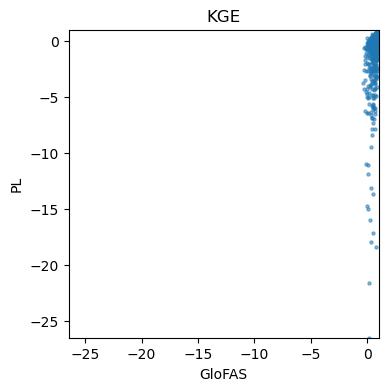

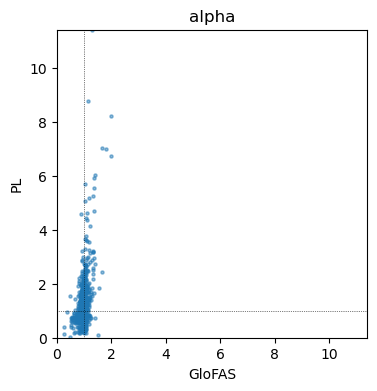

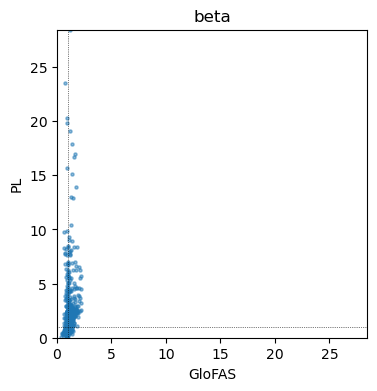

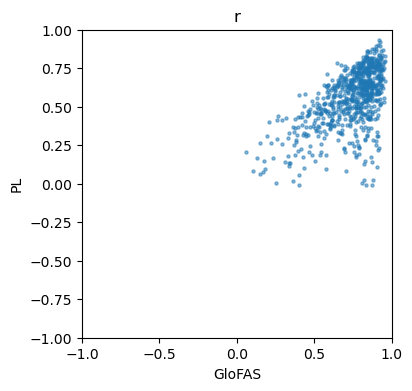

In [24]:
for metric in ['KGE', 'alpha', 'beta', 'r']:

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(performance['glofas'][metric],
               performance['pl'][metric],
               s=5,
               alpha=.5)
    vmin = np.nanmin([df[metric].min() for key, df in performance.items()] + [metrics[metric][0]])
    vmax = np.nanmax([df[metric].max() for key, df in performance.items()] + [metrics[metric][1]])
    ax.axhline(1, c='k', ls=':', lw=.5)
    ax.axvline(1, c='k', ls=':', lw=.5)
    ax.set(
        xlim=(vmin, vmax),
        xlabel='GloFAS',
        ylim=(vmin, vmax),
        ylabel='PL',
        title=metric
    );

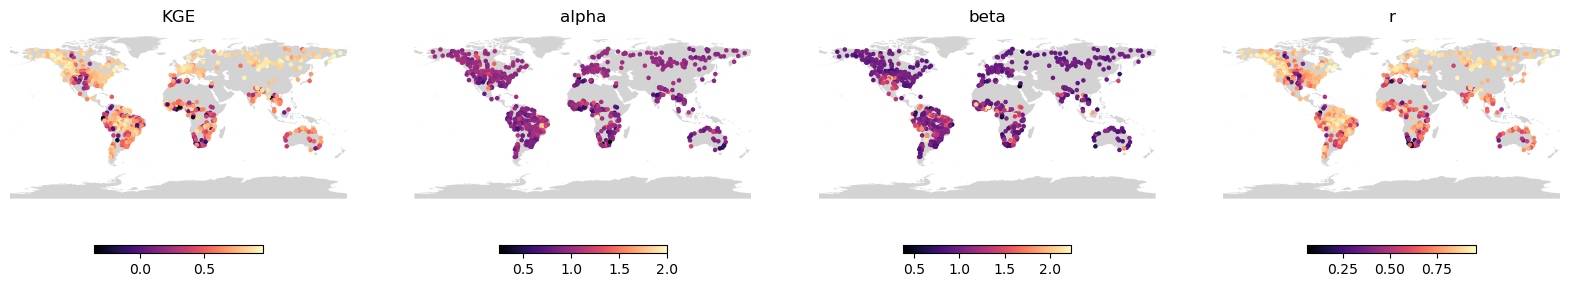

In [29]:
plot_attributes(performance['glofas'],
                catchments.geometry.x,
                catchments.geometry.y,
                ncols=4,
                extent=[-180, 180, -90, 90],
                save=None)

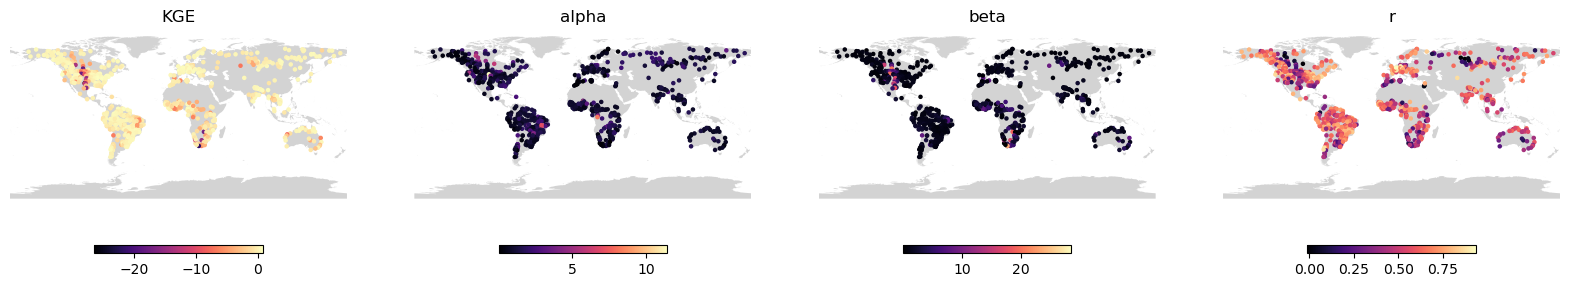

In [30]:
plot_attributes(performance['pl'],
                catchments.geometry.x,
                catchments.geometry.y,
                ncols=4,
                extent=[-180, 180, -90, 90],
                save=None)

### Parameters

In [ ]:
# parameter space
for key, df in parameters.items():
    sns.pairplot(df, corner=True)
    plt.savefig(f'parameter_space_{key}.jpg')#, dpi=300, bbox_inches='tight')

In [33]:
# check exceedances over the search range
pars = parameters['pl']
for parname, parrange in parameter_range.items():
    maskmin = parrange[0] <= pars[parname]
    maskmax = pars[parname] <= parrange[1]
    if all(maskmin & maskmax):
        continue
    else:
        print(parname)
        if sum(~maskmin) > 0:
            print(f'{sum(~maskmin)} basins have a {parname} value below the lower limit')
        if sum(~maskmax) > 0:
            print(sum(~maskmax), 'basins have a {parname} value over the upper limit')

LZTC
1 basins have a LZTC value below the lower limit
SnowMeltCoef
1 basins have a {parname} value over the upper limit
CalChanMan1
1 basins have a {parname} value over the upper limit
LakeMultiplier
1 basins have a LakeMultiplier value below the lower limit


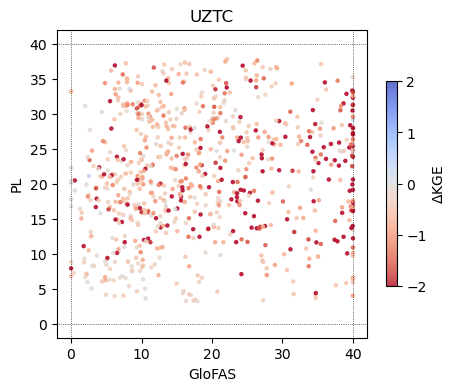

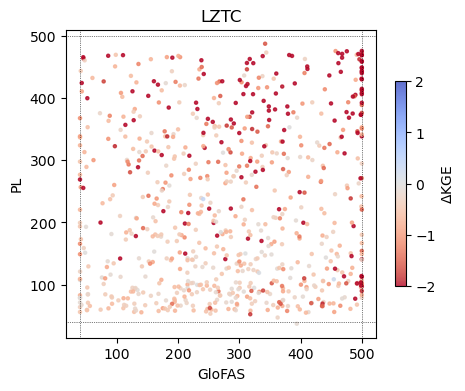

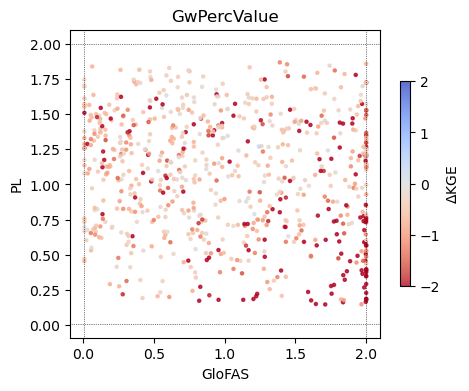

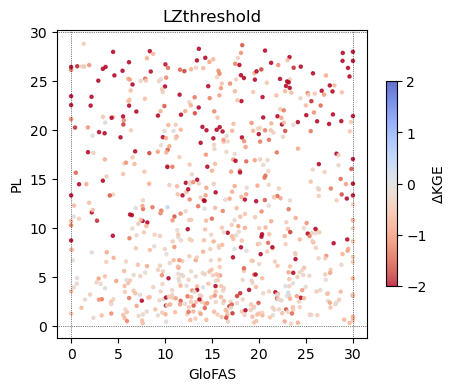

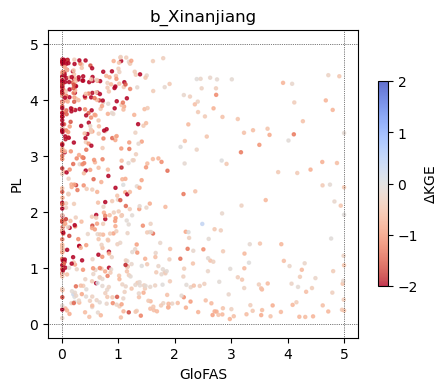

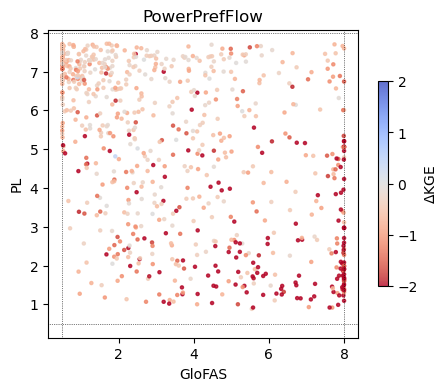

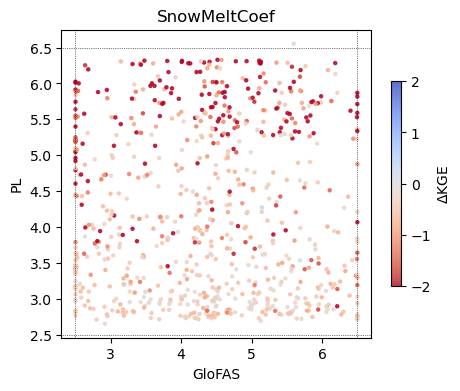

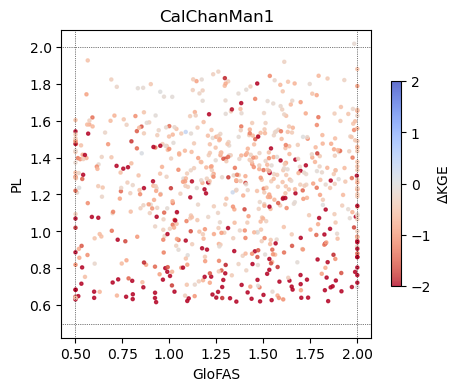

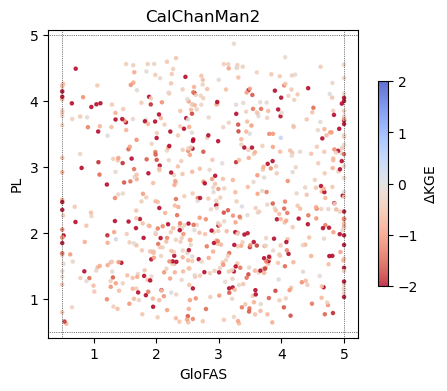

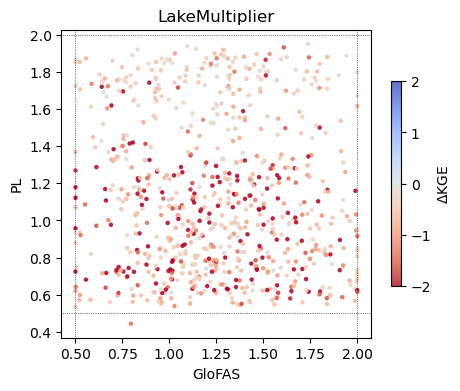

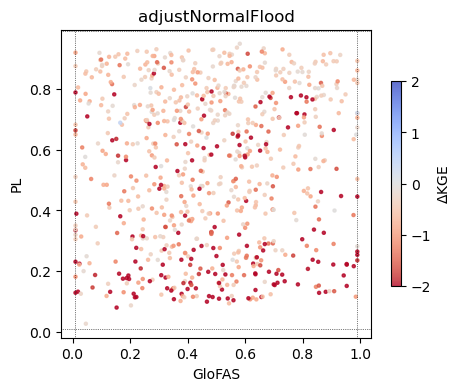

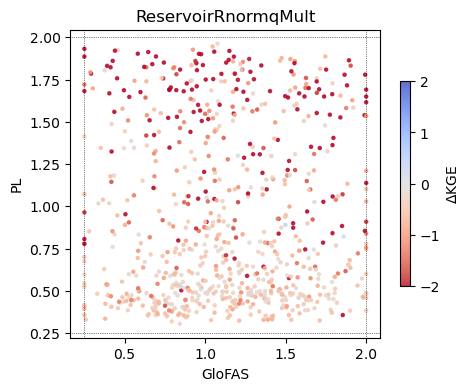

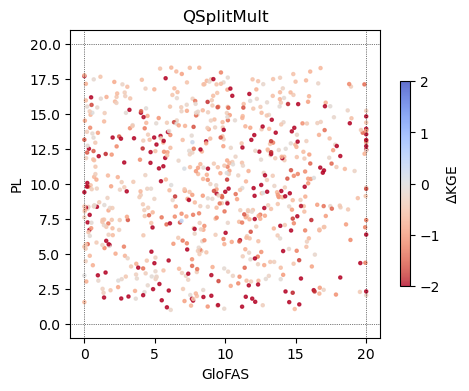

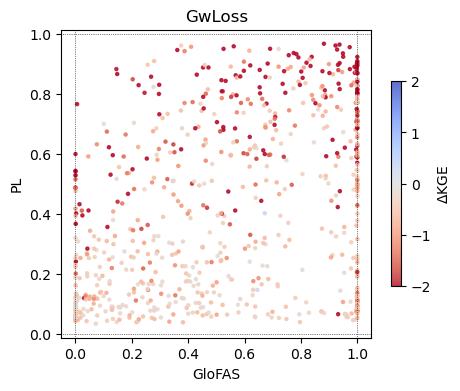

In [34]:
AKGE = performance['pl'].KGE - performance['glofas'].KGE
for par, limits in parameter_range.items():

    fig, ax = plt.subplots(figsize=(5, 4))
    sct = ax.scatter(parameters['glofas'][par],
                     parameters['pl'][par],
                     c=AKGE,
                     cmap='coolwarm_r',
                     vmin=-2, vmax=2,
                     s=5,
                     alpha=0.8)
    for v in limits:
        ax.axhline(v, c='k', ls=':', lw=.5)
        ax.axvline(v, c='k', ls=':', lw=.5)
    ax.set(xlabel='GloFAS',
           ylabel='PL',
           title=par);
    
    plt.colorbar(sct, label=r'$\Delta$KGE', shrink=.666)
    
    plt.savefig(f'{par}.jpg', dpi=300, bbox_inches='tight')

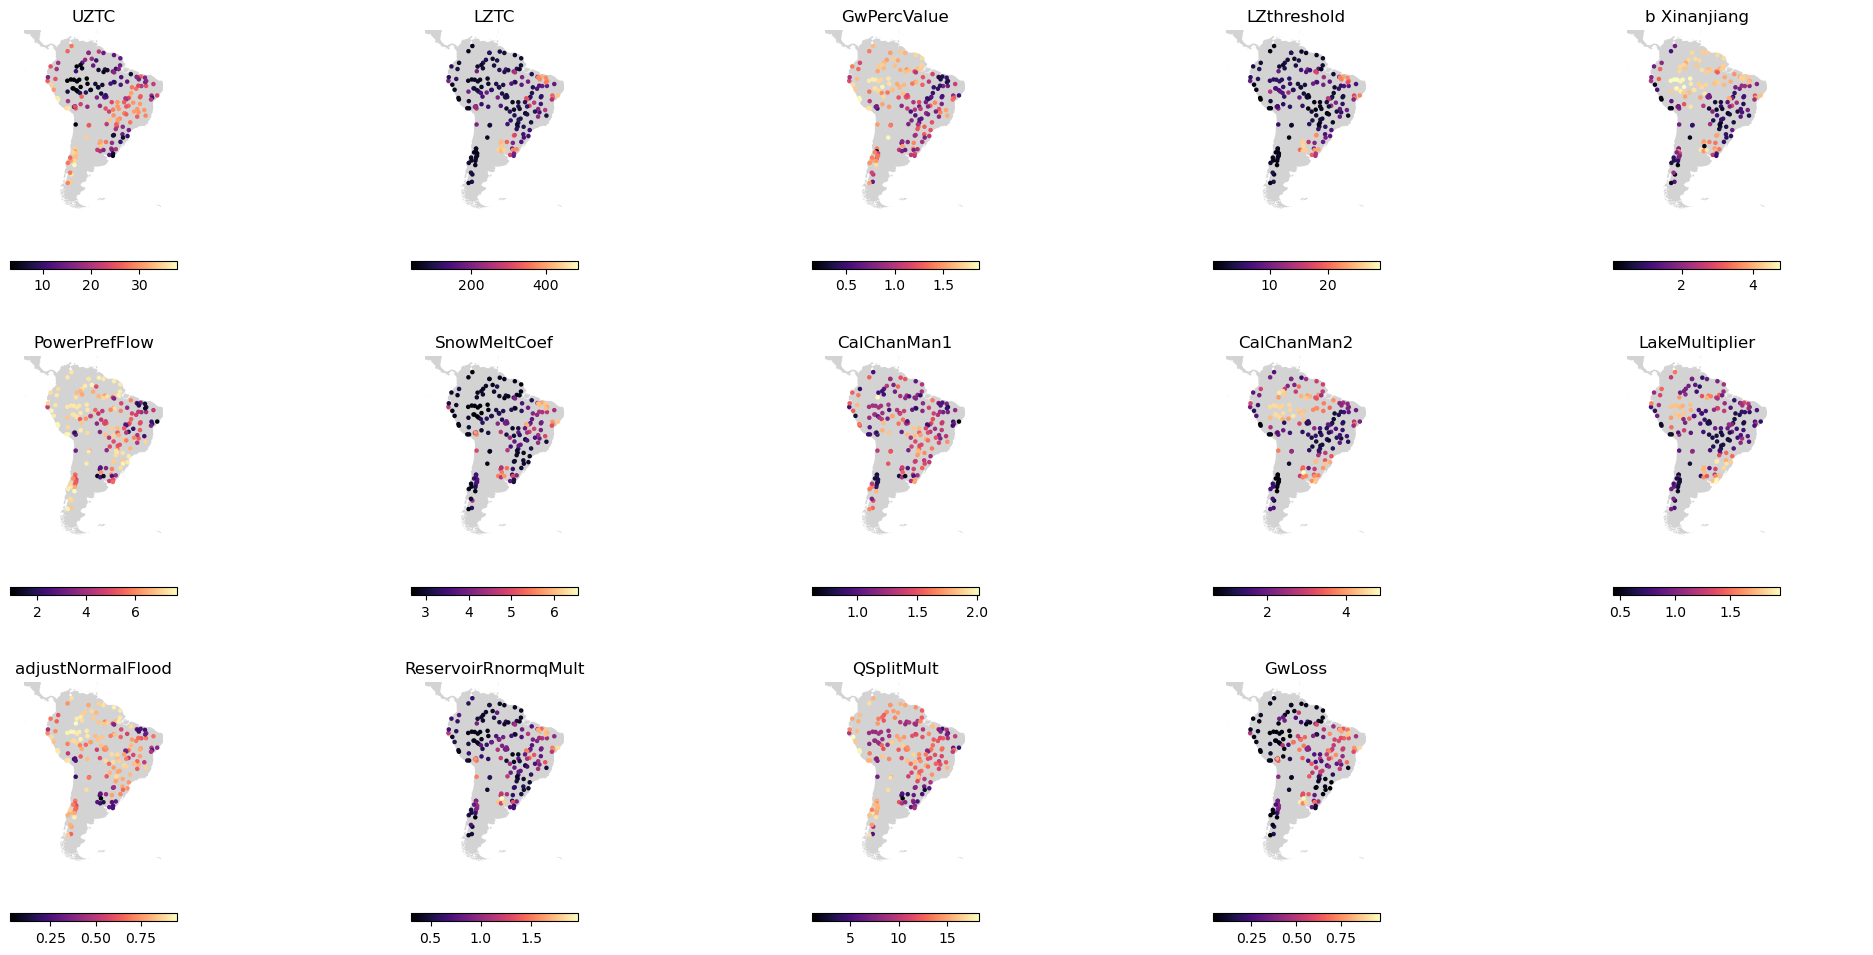

In [51]:
plot_attributes(parameters['pl'],
                catchments.geometry.x,
                catchments.geometry.y,
                ncols=5,
                # extent=[-180, 180, -90, 90],
                extent=[-90, -35, -60, 15],
                save=None)

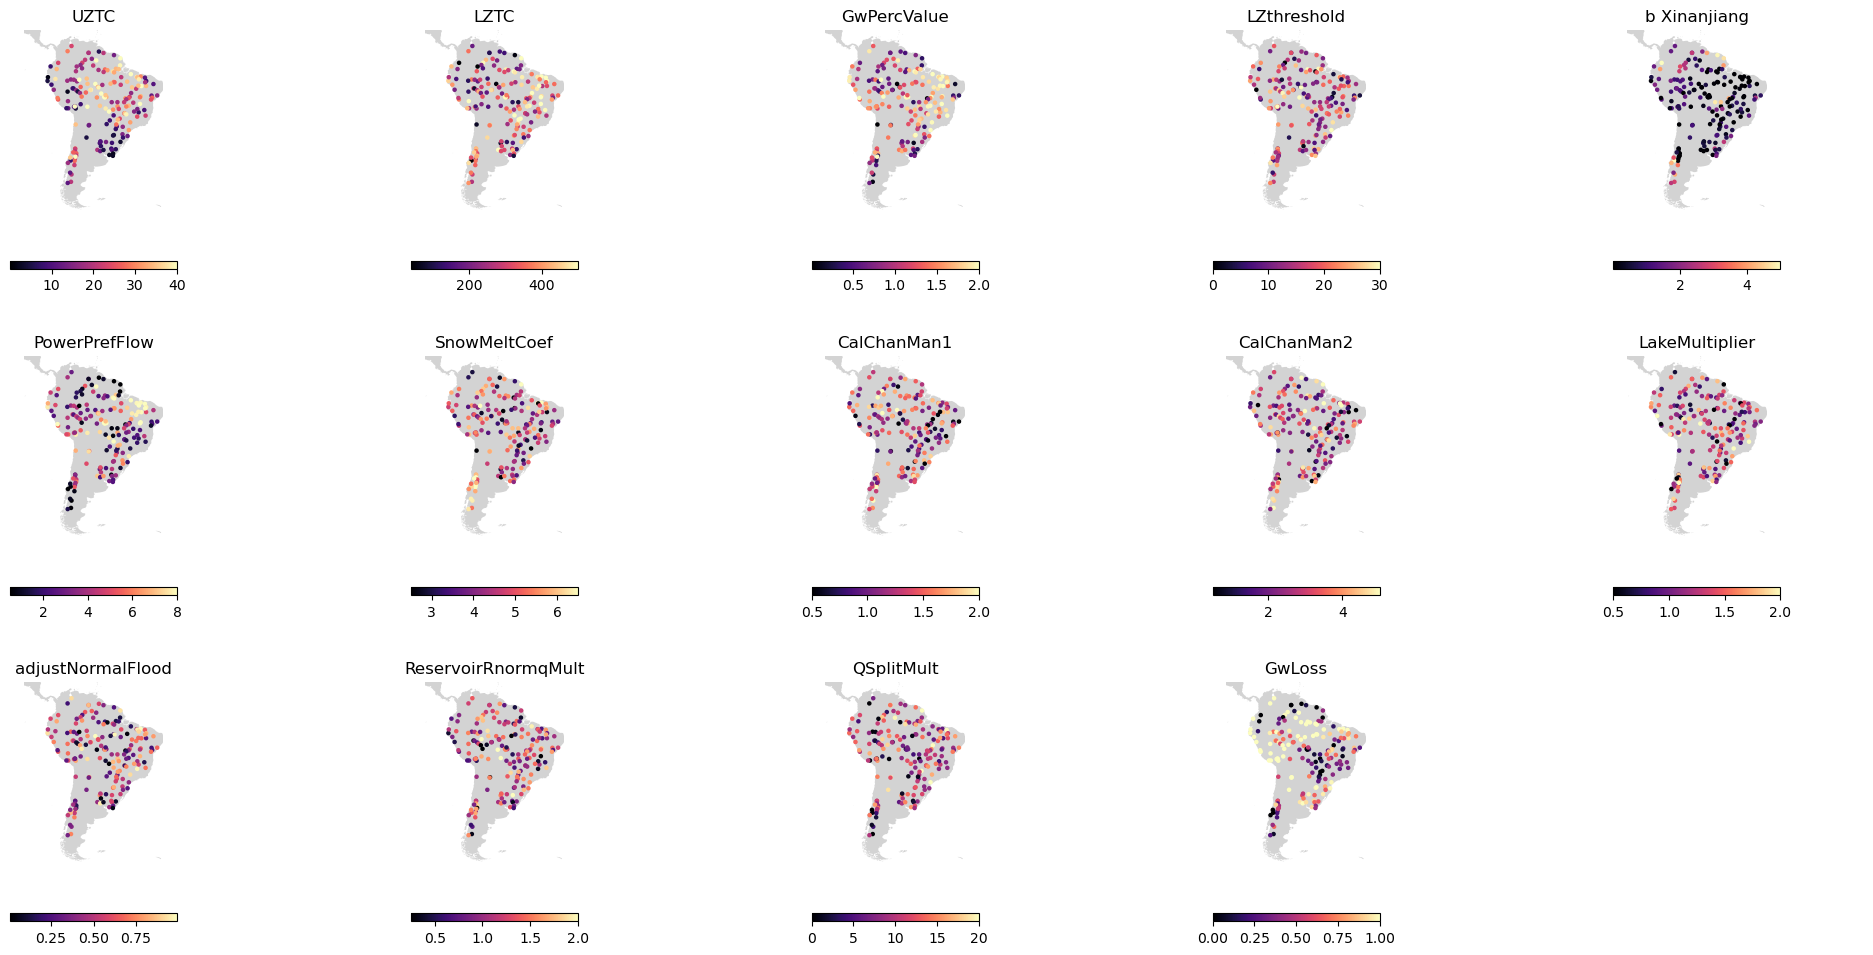

In [52]:
plot_attributes(parameters['glofas'],
                catchments.geometry.x,
                catchments.geometry.y,
                ncols=5,
                # extent=[-180, 180, -90, 90],
                extent=[-90, -35, -60, 15],
                save=None)